In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [27]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [28]:
class DNN(nn.Module):
    def __init__(self, input_dim,hidden_units1,hidden_units2,hidden_units3,hidden_units4,dropout_rate):
        super(DNN, self).__init__()
        self.layer1 = nn.Linear(input_dim,hidden_units1)
        self.layer2 = nn.Linear(hidden_units1,hidden_units2)
        self.layer3 = nn.Linear(hidden_units2, hidden_units3)
        self.layer4 = nn.Linear(hidden_units3, hidden_units4)
        self.output_layer = nn.Linear(hidden_units4, 1)

        self.dropout = nn.Dropout(dropout_rate)

        self.bn1 = nn.BatchNorm1d(hidden_units1)
        self.bn2 = nn.BatchNorm1d(hidden_units2)
        self.bn3 = nn.BatchNorm1d(hidden_units3)
        self.bn4 = nn.BatchNorm1d(hidden_units4)

        
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout(x)
        
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout(x)

        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout(x)

        x = torch.relu(self.bn4(self.layer4(x)))
        x = self.dropout(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [29]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

Optunaの設定

In [30]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    hidden_units1 = trial.suggest_int("hidden_units1", 216, 512, step=2)
    hidden_units2 = trial.suggest_int("hidden_units2", 128, 216, step=2)
    hidden_units3 = trial.suggest_int("hidden_units3", 64, 128, step=2)
    hidden_units4 = trial.suggest_int("hidden_units4", 4, 64, step=2)
    dropout_rate = trial.suggest_float("dropout_rate", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整

    # モデルの定義
    model = DNN(
        input_dim=X_train_tensor.shape[1],
        hidden_units1=hidden_units1,
        hidden_units2=hidden_units2,
        hidden_units3=hidden_units3,
        hidden_units4=hidden_units4,
        dropout_rate=dropout_rate
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val).item()
                predictions = (val_outputs >= 0.5).float()  # 閾値を標準の0.5に設定
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stoppingの判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaのプルーニング機能
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  


最適化

In [31]:
device_id = 0  
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-11-29 18:13:08,217] A new study created in memory with name: no-name-d40be612-70b5-446d-af33-b75489d7e48b
/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:13:16,397] Trial 0 finished with value: 0.0 and parameters: {'hidden_units1': 308, 'hidden_units2': 140, 'hidden_units3': 128, 'hidden_units4': 6, 'dropout_rate': 0.4, 'learning_rate': 0.004926340154805087, 'weight_decay':

Early stopping at epoch 15
Final MCC: 0.0000


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:13:27,705] Trial 1 finished with value: 0.0 and parameters: {'hidden_units1': 318, 'hidden_units2': 194, 'hidden_units3': 96, 'hidden_units4': 40, 'dropout_rate': 0.45, 'learning_rate': 0.008851692399792303, 'weight_decay': 5.57955443184951e-05}. Best is trial 0 with value: 0.0.


Early stopping at epoch 23
Final MCC: 0.0000


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:13:46,566] Trial 2 finished with value: 0.10192943828752511 and parameters: {'hidden_units1': 368, 'hidden_units2': 184, 'hidden_units3': 74, 'hidden_units4': 4, 'dropout_rate': 0.2, 'learning_rate': 0.00013850636399932915, 'weight_decay': 0.00020273284025342284}. Best is trial 2 with value: 0.10192943828752511.


Early stopping at epoch 39
Final MCC: 0.1019


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:13:57,091] Trial 3 finished with value: 0.14341902915111934 and parameters: {'hidden_units1': 460, 'hidden_units2': 204, 'hidden_units3': 110, 'hidden_units4': 52, 'dropout_rate': 0.15000000000000002, 'learning_rate': 0.00016387364512510073, 'weight_decay': 1.4460398869349947e-05}. Best is trial 3 with value: 0.14341902915111934.


Early stopping at epoch 21
Final MCC: 0.1434


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:14:05,676] Trial 4 finished with value: 0.20282434500939742 and parameters: {'hidden_units1': 348, 'hidden_units2': 146, 'hidden_units3': 94, 'hidden_units4': 40, 'dropout_rate': 0.15000000000000002, 'learning_rate': 0.00042941364659334377, 'weight_decay': 0.00030708868423261725}. Best is trial 4 with value: 0.20282434500939742.


Early stopping at epoch 16
Final MCC: 0.2028


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:14:54,123] Trial 5 finished with value: 0.13015393292219313 and parameters: {'hidden_units1': 258, 'hidden_units2': 162, 'hidden_units3': 96, 'hidden_units4': 62, 'dropout_rate': 0.5, 'learning_rate': 0.00012744885564765665, 'weight_decay': 0.00012482448624337838}. Best is trial 4 with value: 0.20282434500939742.


Final MCC: 0.1302


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:15:22,027] Trial 6 finished with value: 0.19237062288668477 and parameters: {'hidden_units1': 500, 'hidden_units2': 164, 'hidden_units3': 114, 'hidden_units4': 64, 'dropout_rate': 0.4, 'learning_rate': 0.00010238737118485333, 'weight_decay': 3.5678824300547964e-05}. Best is trial 4 with value: 0.20282434500939742.


Early stopping at epoch 56
Final MCC: 0.1924


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:15:22,543] Trial 7 pruned. 
[I 2024-11-29 18:16:03,572] Trial 8 finished with value: 0.09243468979503967 and parameters: {'hidden_units1': 454, 'hidden_units2': 216, 'hidden_units3': 74, 'hidden_units4': 4, 'dropout_rate': 0.4, 'learning_rate': 0.00011742958095593759, 'weight_decay': 6.1002167223337814e-05}. Best is trial 4 with value

Early stopping at epoch 84
Final MCC: 0.0924


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:16:04,054] Trial 9 pruned. 
[I 2024-11-29 18:16:04,547] Trial 10 pruned. 
[I 2024-11-29 18:16:05,039] Trial 11 pruned. 
[I 2024-11-29 18:16:05,589] Trial 12 pruned. 
[I 2024-11-29 18:16:06,089] Trial 13 pruned. 
[I 2024-11-29 18:16:06,508] Trial 14 pruned. 
[I 2024-11-29 18:16:06,987] Trial 15 pruned. 
[I 2024-11-29 18:16:07,518] Tria

Early stopping at epoch 15
Final MCC: 0.1708


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:16:15,877] Trial 18 pruned. 
[I 2024-11-29 18:16:16,410] Trial 19 pruned. 
[I 2024-11-29 18:16:16,972] Trial 20 pruned. 
[I 2024-11-29 18:16:17,533] Trial 21 pruned. 
[I 2024-11-29 18:16:24,275] Trial 22 finished with value: 0.14403216146389392 and parameters: {'hidden_units1': 286, 'hidden_units2': 136, 'hidden_units3': 122, 'hidden_

Early stopping at epoch 14
Final MCC: 0.1440


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:16:24,824] Trial 23 pruned. 
[I 2024-11-29 18:16:25,397] Trial 24 pruned. 
[I 2024-11-29 18:16:25,919] Trial 25 pruned. 
[I 2024-11-29 18:16:26,464] Trial 26 pruned. 
[I 2024-11-29 18:16:27,029] Trial 27 pruned. 
[I 2024-11-29 18:16:27,551] Trial 28 pruned. 
[I 2024-11-29 18:16:48,252] Trial 29 finished with value: 0.3182192318053801 

Early stopping at epoch 41
Final MCC: 0.3182


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:17:10,241] Trial 30 finished with value: 0.26521925128957025 and parameters: {'hidden_units1': 332, 'hidden_units2': 144, 'hidden_units3': 128, 'hidden_units4': 58, 'dropout_rate': 0.5, 'learning_rate': 0.0001927644332330867, 'weight_decay': 0.003515563819949543}. Best is trial 29 with value: 0.3182192318053801.


Early stopping at epoch 46
Final MCC: 0.2652


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:17:45,629] Trial 31 finished with value: 0.1387375951238592 and parameters: {'hidden_units1': 334, 'hidden_units2': 148, 'hidden_units3': 126, 'hidden_units4': 58, 'dropout_rate': 0.5, 'learning_rate': 0.00010356090894174411, 'weight_decay': 0.003818955536352953}. Best is trial 29 with value: 0.3182192318053801.


Early stopping at epoch 74
Final MCC: 0.1387


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:18:10,192] Trial 32 finished with value: 0.14934573132646875 and parameters: {'hidden_units1': 308, 'hidden_units2': 134, 'hidden_units3': 114, 'hidden_units4': 58, 'dropout_rate': 0.45, 'learning_rate': 0.00018706686018427225, 'weight_decay': 0.004695821967852315}. Best is trial 29 with value: 0.3182192318053801.


Early stopping at epoch 50
Final MCC: 0.1493


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:18:39,830] Trial 33 finished with value: 0.12894747184908975 and parameters: {'hidden_units1': 372, 'hidden_units2': 144, 'hidden_units3': 122, 'hidden_units4': 62, 'dropout_rate': 0.5, 'learning_rate': 0.00015022282786101435, 'weight_decay': 0.000919890687759764}. Best is trial 29 with value: 0.3182192318053801.


Early stopping at epoch 62
Final MCC: 0.1289


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:18:40,367] Trial 34 pruned. 
[I 2024-11-29 18:18:40,883] Trial 35 pruned. 
[I 2024-11-29 18:18:41,313] Trial 36 pruned. 
[I 2024-11-29 18:19:09,304] Trial 37 finished with value: 0.2820872109772377 and parameters: {'hidden_units1': 294, 'hidden_units2': 132, 'hidden_units3': 78, 'hidden_units4': 60, 'dropout_rate': 0.5, 'learning_rate

Early stopping at epoch 58
Final MCC: 0.2821


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:19:30,709] Trial 38 finished with value: 0.23460866934707042 and parameters: {'hidden_units1': 304, 'hidden_units2': 130, 'hidden_units3': 72, 'hidden_units4': 56, 'dropout_rate': 0.5, 'learning_rate': 0.00012953076748534458, 'weight_decay': 0.0010481642030568206}. Best is trial 29 with value: 0.3182192318053801.


Early stopping at epoch 43
Final MCC: 0.2346


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:20:03,171] Trial 39 finished with value: 0.059674683911495795 and parameters: {'hidden_units1': 302, 'hidden_units2': 130, 'hidden_units3': 64, 'hidden_units4': 56, 'dropout_rate': 0.5, 'learning_rate': 0.00013812023291733094, 'weight_decay': 0.0009791622099070182}. Best is trial 29 with value: 0.3182192318053801.


Early stopping at epoch 66
Final MCC: 0.0597


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:20:26,697] Trial 40 finished with value: 0.10921747468225411 and parameters: {'hidden_units1': 262, 'hidden_units2': 132, 'hidden_units3': 74, 'hidden_units4': 60, 'dropout_rate': 0.5, 'learning_rate': 0.0001960110250967063, 'weight_decay': 0.002279179297394279}. Best is trial 29 with value: 0.3182192318053801.


Early stopping at epoch 48
Final MCC: 0.1092


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:21:05,767] Trial 41 finished with value: 0.1460888308520382 and parameters: {'hidden_units1': 316, 'hidden_units2': 144, 'hidden_units3': 70, 'hidden_units4': 52, 'dropout_rate': 0.45, 'learning_rate': 0.00012910007532052534, 'weight_decay': 0.0015353694561590916}. Best is trial 29 with value: 0.3182192318053801.


Early stopping at epoch 80
Final MCC: 0.1461


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:21:50,625] Trial 42 finished with value: 0.3255713425114916 and parameters: {'hidden_units1': 290, 'hidden_units2': 136, 'hidden_units3': 80, 'hidden_units4': 46, 'dropout_rate': 0.5, 'learning_rate': 0.00010137624965811265, 'weight_decay': 0.0004622653802629724}. Best is trial 42 with value: 0.3255713425114916.


Early stopping at epoch 92
Final MCC: 0.3256


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:22:22,807] Trial 43 finished with value: 0.21261152770157649 and parameters: {'hidden_units1': 300, 'hidden_units2': 138, 'hidden_units3': 78, 'hidden_units4': 46, 'dropout_rate': 0.5, 'learning_rate': 0.00010469990334121129, 'weight_decay': 0.00044709086527900766}. Best is trial 42 with value: 0.3255713425114916.


Early stopping at epoch 65
Final MCC: 0.2126


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:22:23,314] Trial 44 pruned. 
[I 2024-11-29 18:22:23,802] Trial 45 pruned. 
[I 2024-11-29 18:22:24,349] Trial 46 pruned. 
[I 2024-11-29 18:22:24,879] Trial 47 pruned. 
[I 2024-11-29 18:22:51,926] Trial 48 finished with value: 0.12976190476190477 and parameters: {'hidden_units1': 318, 'hidden_units2': 152, 'hidden_units3': 68, 'hidden_u

Early stopping at epoch 56
Final MCC: 0.1298


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:22:52,435] Trial 49 pruned. 
[I 2024-11-29 18:22:52,980] Trial 50 pruned. 
[I 2024-11-29 18:23:39,482] Trial 51 finished with value: 0.34288268083782364 and parameters: {'hidden_units1': 296, 'hidden_units2': 138, 'hidden_units3': 78, 'hidden_units4': 44, 'dropout_rate': 0.5, 'learning_rate': 0.00010073112489286558, 'weight_decay': 0.

Final MCC: 0.3429


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:24:23,771] Trial 52 finished with value: 0.2076159723797994 and parameters: {'hidden_units1': 268, 'hidden_units2': 200, 'hidden_units3': 74, 'hidden_units4': 46, 'dropout_rate': 0.5, 'learning_rate': 0.00014600501186337196, 'weight_decay': 0.0005398184992967472}. Best is trial 51 with value: 0.34288268083782364.


Early stopping at epoch 92
Final MCC: 0.2076


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:24:24,330] Trial 53 pruned. 
[I 2024-11-29 18:24:52,315] Trial 54 finished with value: 0.27630104402889527 and parameters: {'hidden_units1': 310, 'hidden_units2': 132, 'hidden_units3': 84, 'hidden_units4': 56, 'dropout_rate': 0.5, 'learning_rate': 0.00011585902064167591, 'weight_decay': 0.0028505308492928123}. Best is trial 51 with va

Early stopping at epoch 57
Final MCC: 0.2763


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:24:52,812] Trial 55 pruned. 
[I 2024-11-29 18:25:38,839] Trial 56 finished with value: 0.23329951761944553 and parameters: {'hidden_units1': 280, 'hidden_units2': 148, 'hidden_units3': 86, 'hidden_units4': 60, 'dropout_rate': 0.5, 'learning_rate': 0.00011466698354225449, 'weight_decay': 0.0014959924036064382}. Best is trial 51 with va

Early stopping at epoch 94
Final MCC: 0.2333


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:25:39,369] Trial 57 pruned. 
[I 2024-11-29 18:25:39,912] Trial 58 pruned. 
[I 2024-11-29 18:25:40,442] Trial 59 pruned. 
[I 2024-11-29 18:26:27,394] Trial 60 finished with value: 0.11470693239496259 and parameters: {'hidden_units1': 254, 'hidden_units2': 138, 'hidden_units3': 80, 'hidden_units4': 48, 'dropout_rate': 0.45, 'learning_ra

Final MCC: 0.1147


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:27:14,431] Trial 61 finished with value: 0.09910049688283866 and parameters: {'hidden_units1': 308, 'hidden_units2': 134, 'hidden_units3': 82, 'hidden_units4': 56, 'dropout_rate': 0.5, 'learning_rate': 0.00012124608247841463, 'weight_decay': 0.0012018944317148525}. Best is trial 51 with value: 0.34288268083782364.


Final MCC: 0.0991


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:27:14,839] Trial 62 pruned. 
[I 2024-11-29 18:27:15,237] Trial 63 pruned. 
[I 2024-11-29 18:27:15,745] Trial 64 pruned. 
[I 2024-11-29 18:27:16,350] Trial 65 pruned. 
[I 2024-11-29 18:28:02,567] Trial 66 finished with value: 0.29549860684880325 and parameters: {'hidden_units1': 336, 'hidden_units2': 150, 'hidden_units3': 88, 'hidden_u

Final MCC: 0.2955


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:28:03,172] Trial 67 pruned. 
[I 2024-11-29 18:28:03,801] Trial 68 pruned. 
[I 2024-11-29 18:28:04,431] Trial 69 pruned. 
[I 2024-11-29 18:28:05,040] Trial 70 pruned. 
[I 2024-11-29 18:28:05,639] Trial 71 pruned. 
[I 2024-11-29 18:28:06,247] Trial 72 pruned. 
[I 2024-11-29 18:28:06,815] Trial 73 pruned. 
[I 2024-11-29 18:28:07,208] Tri

Early stopping at epoch 33
Final MCC: 0.2419


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:28:52,363] Trial 77 finished with value: 0.3117538231685599 and parameters: {'hidden_units1': 344, 'hidden_units2': 150, 'hidden_units3': 84, 'hidden_units4': 52, 'dropout_rate': 0.45, 'learning_rate': 0.00010161075535340397, 'weight_decay': 0.00484226390959947}. Best is trial 51 with value: 0.34288268083782364.


Early stopping at epoch 55
Final MCC: 0.3118


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:28:52,916] Trial 78 pruned. 
[I 2024-11-29 18:28:53,452] Trial 79 pruned. 
[I 2024-11-29 18:28:54,008] Trial 80 pruned. 
[I 2024-11-29 18:28:54,575] Trial 81 pruned. 
[I 2024-11-29 18:28:55,098] Trial 82 pruned. 
[I 2024-11-29 18:28:55,707] Trial 83 pruned. 
[I 2024-11-29 18:28:56,202] Trial 84 pruned. 
[I 2024-11-29 18:28:56,760] Tri

Early stopping at epoch 74
Final MCC: 0.1457


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:29:35,775] Trial 88 pruned. 
[I 2024-11-29 18:29:36,376] Trial 89 pruned. 
[I 2024-11-29 18:29:37,006] Trial 90 pruned. 
[I 2024-11-29 18:29:37,408] Trial 91 pruned. 
[I 2024-11-29 18:29:37,799] Trial 92 pruned. 
[I 2024-11-29 18:29:38,163] Trial 93 pruned. 
[I 2024-11-29 18:30:18,611] Trial 94 finished with value: 0.22245099695814544

Early stopping at epoch 90
Final MCC: 0.2225


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:30:19,164] Trial 95 pruned. 
[I 2024-11-29 18:30:19,702] Trial 96 pruned. 
[I 2024-11-29 18:30:54,547] Trial 97 finished with value: 0.18785216240324265 and parameters: {'hidden_units1': 284, 'hidden_units2': 134, 'hidden_units3': 118, 'hidden_units4': 58, 'dropout_rate': 0.45, 'learning_rate': 0.00019681531181822958, 'weight_decay': 

Early stopping at epoch 71
Final MCC: 0.1879


/tmp/ipykernel_181066/892729681.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_181066/892729681.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-11-29 18:30:54,971] Trial 98 pruned. 
[I 2024-11-29 18:30:55,515] Trial 99 pruned. 


Best Parameters:  {'hidden_units1': 296, 'hidden_units2': 138, 'hidden_units3': 78, 'hidden_units4': 44, 'dropout_rate': 0.5, 'learning_rate': 0.00010073112489286558, 'weight_decay': 0.00047144072058257484}
Best Validation F1:  0.34288268083782364


最適化パラメーターで再学習

Epoch [1/100], Loss: 0.7444
Epoch [1/100], Train Loss: 0.7444, Val Loss: 0.7074
Epoch [2/100], Loss: 0.6997
Epoch [2/100], Train Loss: 0.6997, Val Loss: 0.6765
Epoch [3/100], Loss: 0.6837
Epoch [3/100], Train Loss: 0.6837, Val Loss: 0.6568
Epoch [4/100], Loss: 0.6723
Epoch [4/100], Train Loss: 0.6723, Val Loss: 0.6425
Epoch [5/100], Loss: 0.6564
Epoch [5/100], Train Loss: 0.6564, Val Loss: 0.6224
Epoch [6/100], Loss: 0.6505
Epoch [6/100], Train Loss: 0.6505, Val Loss: 0.6124
Epoch [7/100], Loss: 0.6321
Epoch [7/100], Train Loss: 0.6321, Val Loss: 0.6068
Epoch [8/100], Loss: 0.6224
Epoch [8/100], Train Loss: 0.6224, Val Loss: 0.5996
Epoch [9/100], Loss: 0.6225
Epoch [9/100], Train Loss: 0.6225, Val Loss: 0.5933
Epoch [10/100], Loss: 0.6153
Epoch [10/100], Train Loss: 0.6153, Val Loss: 0.5899
Epoch [11/100], Loss: 0.6201
Epoch [11/100], Train Loss: 0.6201, Val Loss: 0.5879
Epoch [12/100], Loss: 0.6145
Epoch [12/100], Train Loss: 0.6145, Val Loss: 0.5849
Epoch [13/100], Loss: 0.6040
Epoch

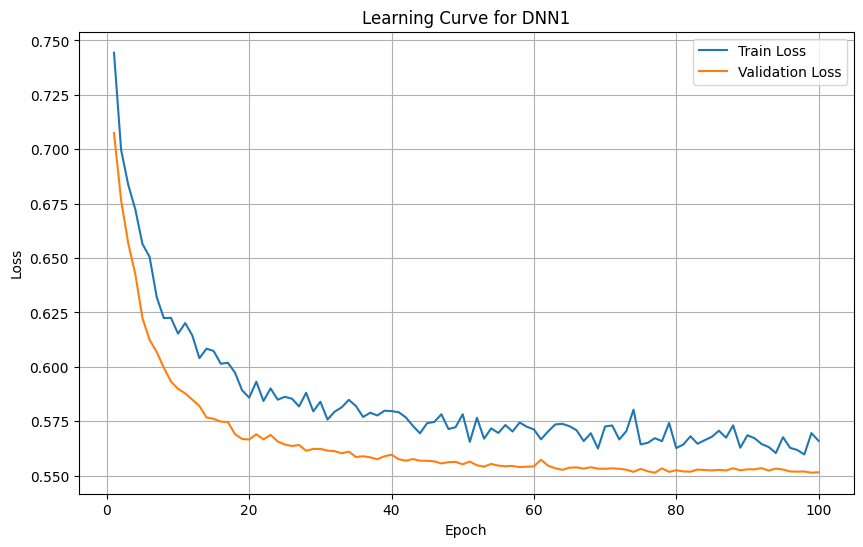

In [32]:
best_params=study.best_params
model = DNN(input_dim=X_train_tensor.shape[1],
            hidden_units1=best_params["hidden_units1"],
            hidden_units2=best_params["hidden_units2"],
            hidden_units3=best_params["hidden_units3"],
            hidden_units4=best_params["hidden_units4"],
            dropout_rate=best_params["dropout_rate"]
            ).to(device)

# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val)
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 60.59%
Precision: 0.4821
Recall: 0.2773
F1 Score: 0.3521
Matthews Correlation Coefficient: 0.1053
Specificity: 0.8126


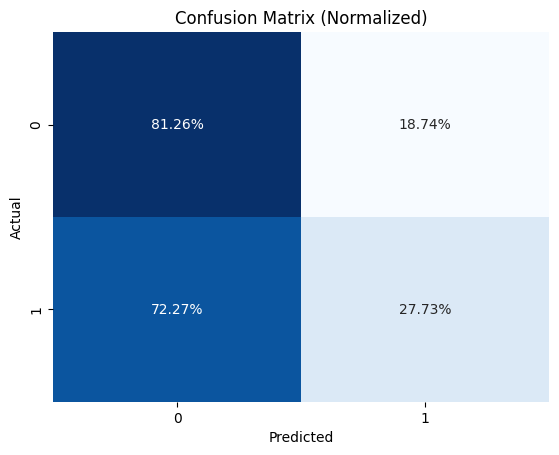

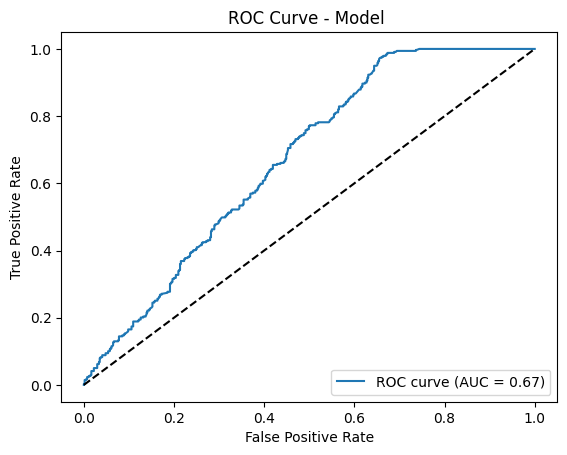

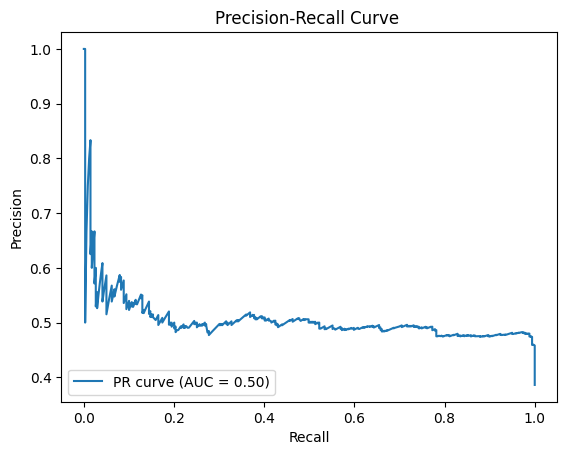

In [33]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >= 0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [34]:
# モデルと構造を保存
torch.save(model, '../../saved_model/DNN_1.pth')
